In [68]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D
)
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
import mlflow

from utils.visualize import plot_accuracy_and_loss

sns.set(style='white', context='notebook', palette='deep')

In [69]:
# this disable the GPU
# tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [70]:
npz_file = np.load('../data/processed/processed_data.npz')
X_train, X_val, Y_train, Y_val = npz_file.values()

In [71]:
mlflow.keras.autolog()

model = Sequential()

model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation='relu',
        input_shape=(28, 28, 1)
    )
)
# model.add(
#     Conv2D(
#         filters=32,
#         kernel_size=(5, 5),
#         padding="Same",
#         activation='relu',
#     )
# )
model.add(
    MaxPool2D(pool_size=(2, 2))
)
model.add(Dropout(0.25))

model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="Same",
        activation='relu'
    )
)
# model.add(
#     Conv2D(
#         filters=64,
#         kernel_size=(3, 3),
#         padding="Same",
#         activation='relu'
#     )
# )
model.add(
    MaxPool2D(pool_size=(2, 2), strides=(2, 2))
)
model.add(Dropout(0.25))

# Flattening the matrix into a vector
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))

## 2.2 Optimizer

- We need to set up a keras optimizer, and choose the _score function_(?) a _loss function_(such as mean squared error) and a _optimization function_(like gradient descent, or stochastic gradient descent) 
- *Keras* has a set of objects that implement these optimizers.

In [72]:
# Hyperparamenters
epochs = 10
batch_size = 30
learning_rate=0.001
rho=0.9
epsilon=1e-08
decay=0.0

MlflowException: Changing param values is not allowed. Param with key='batch_size' was already logged with value='None' for run ID='8618602a81c14fa6a8c2b5ac8dc784bd'. Attempted logging new value '30'.

In [ ]:
# TODO: implement other types of optimizers to see the difference betweem them
# TODO: learn about the RMSProp
optimizer = rmsprop_v2.RMSProp(
     rho=rho, epsilon=epsilon, decay=decay
)

In [ ]:
# TODO: use other types of loss functions and compare the accuracy
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

We're gonna use the `ReduceLROnPlateau` callback.

This class dynamically deacrese the _learning rate_ as the loss came to certain plateou.

This will increase the speed to the learning, because at the beginning we make large steps down the "hill", and as the network learns, we deacrease this number to improve the accuracy

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)


## Data Augmentation
- Is artificially expand the data that we have, creating new variations from the existing ones
- On the mnist problem, where the input data is images, we can rotate, scale, decentralize the image to create a slightly different image
- We're gonna use the `ImageDataGenerator` from keras, to create artificial data

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, # randomly rotate the image
    zoom_range=0.1, # randomly zoom the image
    width_shift_range=0.1, # randomly shift image horizontally
    height_shift_range=0.1, # randomly shilft images
    vertical_flip=False, # randomly flip the image
)

datagen.fit(X_train)

In [ ]:
history = model.fit(
    datagen.flow(
        X_train, Y_train, batch_size=batch_size
    ),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.4326 - accuracy: 0.8619 - val_loss: 0.0813 - val_accuracy: 0.9769
Epoch 2/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.1750 - accuracy: 0.9493 - val_loss: 0.0730 - val_accuracy: 0.9786
Epoch 3/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.1483 - accuracy: 0.9589 - val_loss: 0.0596 - val_accuracy: 0.9829
Epoch 4/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.1392 - accuracy: 0.9619 - val_loss: 0.0729 - val_accuracy: 0.9793
Epoch 5/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.1430 - accuracy: 0.9613 - val_loss: 0.0530 - val_accuracy: 0.9867
Epoch 6/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.1500 - accuracy: 0.9596 - val_loss: 0.0540 - val_accuracy: 0.9862
Epoch 7/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.1511 - accuracy: 0.9598 - val_loss: 0.0461 - val_accuracy:

## Evaluating the network
- Showing the result with the simplest network architecture and with no data augmentation

Best accuracy: 0.967698
Best validation accuracy: 0.989048


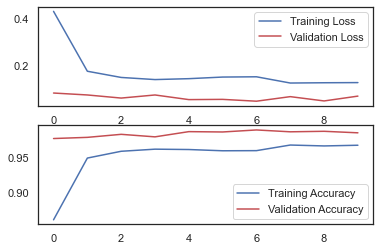

In [ ]:
plot_accuracy_and_loss(history)